In [ ]:
!pip install -U -q PyDrive

In [ ]:
import pandas as pd

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
directory='drive/My Drive/chest_xray/chest_xray',

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'chest_xray/chest_xrayt'})
uploaded.SetContentString('Sample upload file content')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 19Vev4O7Yzp_XmgwWEE1VQcdDT_Zee7pR


In [ ]:
downloaded = drive.CreateFile({'id': uploaded.get('id')})
print('Downloaded content "{}"'.format(downloaded.GetContentString()))

Downloaded content "Sample upload file content"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import MaxPooling2D
from tensorflow.keras.models import Sequential, Model  
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from pathlib import Path

# Load data with path
data_set = Path('/gdrive/My Drive/chest_xray/chest_xray')
train_1 = data_set / 'train'
val_1 = data_set / 'val'
test_1 = data_set / 'test'

#Path to the normal and pneumonia sub-directories
normal_lung = train_1 / 'NORMAL'
pneumonia_lung = train_1 / 'PNEUMONIA'

# Get all the images
normal_0 = normal_lung.glob('*.jpeg')
pneumonia_1 = pneumonia_lung.glob('*.jpeg')

train_data = [] #insert the data into this list

for img in normal_0: #get all the normal cases = 0. 
    train_data.append((img,0))

for img in pneumonia_1: #get all the pneumonia cases = 1. 
    train_data.append((img, 1))
  
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None) #convert with pandas dataframe from the data list
train_data = train_data.sample(frac=1.).reset_index(drop=True) # sample and reset index data 

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5216 non-null   object
 1   label   5216 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.6+ KB


In [ ]:
train_data.describe()

,label
count,5216.000000
mean,0.742906
std,0.437073
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


(array([1341.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3875.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

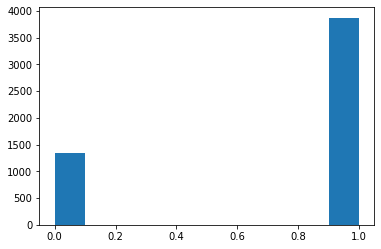

In [ ]:
from matplotlib.pyplot import hist

hist(train_data.label)

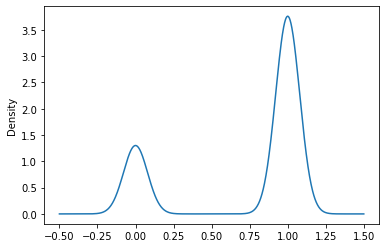

In [ ]:
train_data['label'].plot.density();

Text(0, 0.5, 'Count')

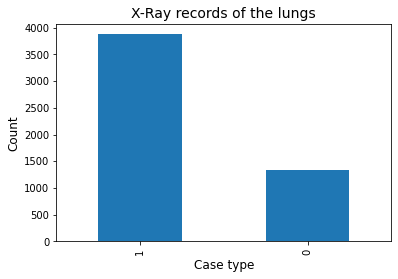

In [ ]:
train_data['label'].value_counts().plot(kind='bar');
plt.title('X-Ray records of the lungs', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


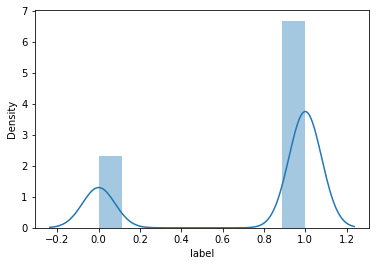

In [ ]:
%matplotlib inline
import seaborn as sns
sns.distplot(train_data['label']);

In [ ]:
import plotly.express as px
import seaborn as sns

cases_count_1 = train_data['label'].value_counts()
px.scatter(x=cases_count_1.index, y= cases_count_1.values, opacity=0.05, trendline='ols')
px.scatter(range(len(cases_count_1.index)), ['lung Normal(0)', 'lung with Pneumonia(1)'])

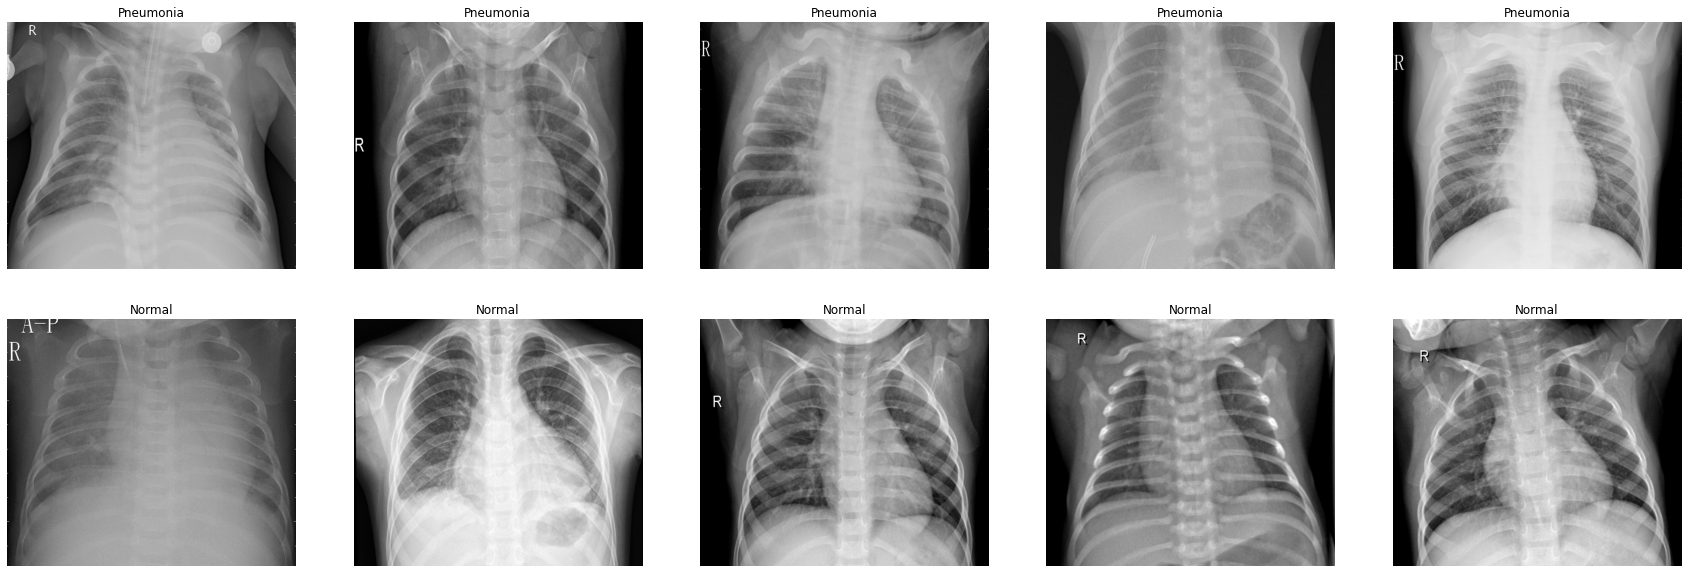

In [ ]:
from skimage.io import imread

#Samples each classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:7]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:7]).tolist()

# Concat the data both list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
f, graph = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    graph[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        graph[i//5, i%5].set_title("Pneumonia")
    else:
        graph[i//5, i%5].set_title("Normal")
    graph[i//5, i%5].axis('off')
    graph[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
batch_size = 16
epochs = 50
img_height = 224
img_width = 224
train_sample = 5217
val_sample = 17

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#Model
resnet = ResNet50(weights='imagenet', include_top=False )

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = GlobalAveragePooling2D()(x) #layer flatten
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(resnet.input, predictions)

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Setup Architecture

custom_cnn = Sequential([
    Conv2D(64, (3,3), input_shape=(224, 224, 3), padding='same', activation='relu'),
    MaxPooling2D((2,2), padding='same'),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(8,(2,2), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
custom_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         5

In [ ]:
train_data = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [ ]:
test_data = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_data.flow_from_directory(
    train_1,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 5217 images belonging to 2 classes.


In [ ]:
validation_generator = test_data.flow_from_directory(
    val_1,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 16 images belonging to 2 classes.


In [ ]:
test_generator = test_data.flow_from_directory(
    test_1,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 624 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_sample // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=val_sample// batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
326/326 [==============================] - 1547s 5s/step - loss: 0.5335 - accuracy: 0.7550 - val_loss: 0.6835 - val_accuracy: 0.5625
Epoch 2/50
326/326 [==============================] - 119s 365ms/step - loss: 0.4303 - accuracy: 0.7958 - val_loss: 0.7854 - val_accuracy: 0.5625
Epoch 3/50
326/326 [==============================] - 118s 363ms/step - loss: 0.4052 - accuracy: 0.8127 - val_loss: 0.7549 - val_accuracy: 0.6250
Epoch 4/50
326/326 [==============================] - 118s 363ms/step - loss: 0.3814 - accuracy: 0.8246 - val_loss: 0.9026 - val_accuracy: 0.5625
Epoch 5/50
326/326 [==============================] - 118s 363ms/step - loss: 0.3557 - accuracy: 0.8404 - val_loss: 1.0104 - val_accuracy: 0.6250
Epoch 6/50
326/326 [==============================] - 118s 363ms/step - loss: 0.3484 - accuracy: 0.8387 - val_loss: 0.8080 - val_accuracy: 0.6250
Epoch 7/50
326/326 [==============================

In [ ]:
# evaluate the model
scores = model.evaluate_generator(test_generator)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Instructions for updating:
Please use Model.evaluate, which supports generators.

accuracy: 84.94%


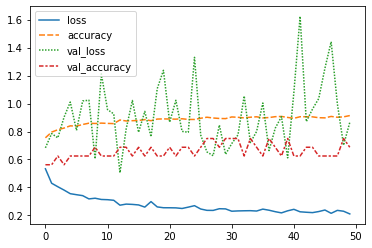

In [ ]:
import pandas as pd
import seaborn as sns

sns.lineplot(data=pd.DataFrame(history.history));

39/39 - 7s - loss: 0.3695 - accuracy: 0.8494


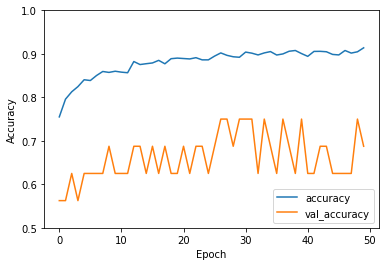

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_generator, verbose=2)

In [ ]:
predictions = model.predict(test_generator)
predictions[0]

array([0.935778], dtype=float32)

In [ ]:
np.argmax(predictions[0])

0

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
import os
from PIL import Image
import numpy as np

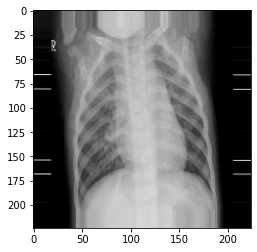

In [ ]:
import matplotlib.pyplot as plt

lung = train_generator[0][0][1]
plt.imshow(lung);

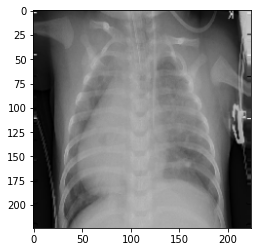

In [ ]:
pneumonia = train_generator[0][0][0]
plt.imshow(pneumonia);

In [ ]:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity

rx_grayscale = rescale_intensity(color.rgb2gray(lung))
rx_grayscale.shape

(224, 224)

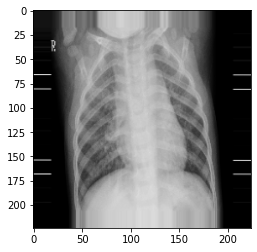

In [ ]:
plt.imshow(rx_grayscale, cmap="gray");

In [ ]:
rx_grayscale.shape

(224, 224)

In [ ]:
import numpy as np
import scipy.ndimage as nd

horizontal_edge_convolution = np.array([[1,1,1],
                                        [0,0,0],
                                        [-1,-1,-1]])

vertical_edge_convolution = np.array([[1, 0, -1],
                                     [1, 0, -1],
                                     [1, 0, -1]])

rx_horizontal = nd.convolve(rx_grayscale, horizontal_edge_convolution)
rx_vertical = nd.convolve(rx_grayscale, vertical_edge_convolution)

rx_horizontal.shape

(224, 224)

In [ ]:
rx_grayscale[0,0]

0.07560359

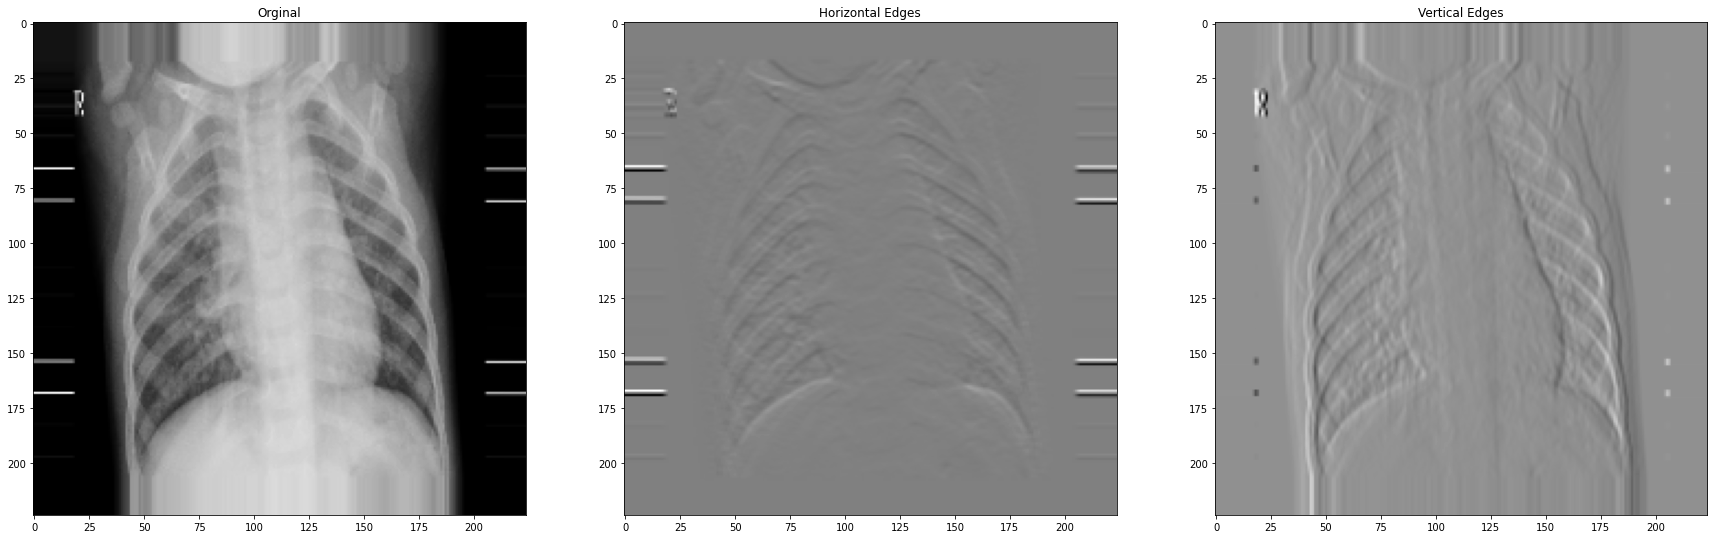

In [ ]:
plt.figure(figsize=(30,10))

labels = ["Orginal", "Horizontal Edges", "Vertical Edges"]
images = [rx_grayscale, rx_horizontal, rx_vertical]

i = 0
for label, image in zip(labels, images):

    plt.subplot(1,3,i+1)
    plt.grid(False)
    plt.imshow(image, cmap="gray")
    plt.title(label)
    i += 1 

plt.show()

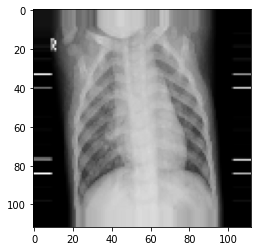

In [ ]:
from skimage.measure import block_reduce

reduced = block_reduce(rx_grayscale, (2,2), np.max)
plt.imshow(reduced, cmap="gray");